# Techno
Techno is a strategy based purely on technical indicators. The work is originated by Leon and reproduced by Jiawei.

In [6]:
from functools import reduce
import numpy as np
import pandas as pd
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import plot_roc_curve
from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from xgboost import XGBClassifier
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(context="notebook", style="whitegrid", color_codes=True)
pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)
np.seterr(divide="ignore", invalid="ignore")
import warnings
warnings.filterwarnings("ignore")
from build import build_features
from build import build_labels
from build import build_train_test
from backtest import backtest_report

In [7]:
def compute_rsi(data, window):
    diff = data.diff(1)
    up_chg = 0 * diff
    down_chg = 0 * diff
    up_chg[diff > 0] = diff[diff > 0]
    down_chg[diff < 0] = diff[diff < 0]
    up_chg_avg = up_chg.ewm(com=window - 1, min_periods=window).mean()
    down_chg_avg = down_chg.ewm(com=window - 1, min_periods=window).mean()
    rs = abs(up_chg_avg / down_chg_avg)
    rsi = 1 - 1 / (1 + rs)
    return rsi

In [8]:
def techno(df):
    windows = [3, 4, 5, 10, 20, 40]
    df["pct_1m"] = df.close.groupby("gvkey").transform(lambda x: x.pct_change(1))
    for window in windows:
        df[f"std_{window}m"] = df.pct_1m.groupby("gvkey").transform(lambda x: x.rolling(window).std())
        df[f"sh_{window}m"] = df.pct_1m.groupby("gvkey").transform(lambda x: x.rolling(window).mean() / x.rolling(window).std())
        df[f"pct_{window}m"] = df.close.groupby("gvkey").transform(lambda x: x.pct_change(window - 1))
        df[f"ema_{window}m"] = df.close.groupby("gvkey").transform(lambda x: x / x.ewm(span=window, adjust=False).mean() -1 )
        df[f"qt_{window}m"] = df.close.groupby("gvkey").transform(lambda x: x.rolling(window).quantile(0.75) / x)
        df[f"scosc_{window}m"] = df.close.groupby("gvkey").transform(lambda x: (x - x.rolling(window).min()) / (x.rolling(window).max() - x.rolling(window).min()))
        df[f"rsi_{window}m"] = df.close.groupby("gvkey").transform(lambda x: compute_rsi(x, window))
    return df.loc[(df.mcap > 1e6) & (df.prccd>5), "high":].drop(columns=["volume", "close"]).dropna()

In [9]:
# select stocks with market cap > 1 million, trading price > 5 as stock universe
raw = pd.read_parquet("../data/raw-beta.1.parquet")
gvkeys = raw[(raw.mcap > 1e6) & (raw.prccd > 5)].index.get_level_values("gvkey").unique()
universe = raw.loc[gvkeys]

In [10]:
features = build_features(universe, techno, scale=None)

In [11]:
labels = build_labels(universe, months=3, relative=False)

In [18]:
X_train, y_train, X_test, y_test = build_train_test(
    features,
    labels,
    train_start="2002-01-01",
    train_end="2012-01-01",
    test_start="2012-01-01",
    test_end="2016-01-01",
    method="multi",
    thres=0.03, 
    extreme=False)

Classification report on training set:

              precision    recall  f1-score   support

          -1       0.61      0.56      0.59     36566
           0       0.67      0.13      0.22     19690
           1       0.55      0.79      0.65     41771

    accuracy                           0.57     98027
   macro avg       0.61      0.50      0.49     98027
weighted avg       0.60      0.57      0.54     98027

Classification report on test set:

              precision    recall  f1-score   support

          -1       0.35      0.38      0.37     14148
           0       0.46      0.10      0.17     10723
           1       0.47      0.63      0.54     21048

    accuracy                           0.43     45919
   macro avg       0.43      0.37      0.36     45919
weighted avg       0.43      0.43      0.40     45919



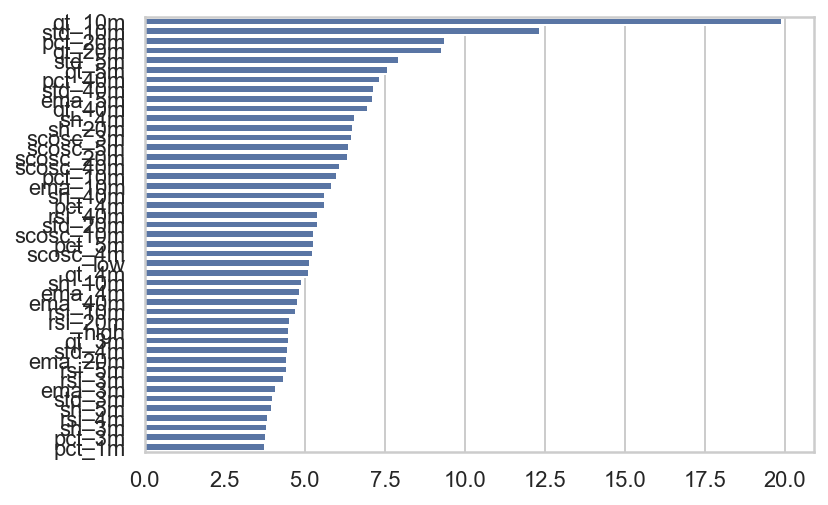

In [30]:
xgb_clf = XGBClassifier(n_estimators=100, max_depth=5, n_jobs=-1, eval_metric="logloss")
xgb_fit = xgb_clf.fit(X_train, y_train)
importance = pd.Series(data=xgb_clf.get_booster().get_score(importance_type="gain")).sort_values(ascending=False)
ax = sns.barplot(x=importance, y=importance.index, color="b")
print(f"Classification report on training set:\n")
print(classification_report(y_train, xgb_clf.predict(X_train)))
print(f"Classification report on test set:\n")
print(classification_report(y_test, xgb_clf.predict(X_test)))

In [31]:
data=pd.read_parquet("../data/backtest_5-0.1.parquet")

Short Only Sharpe Ratio: 0.8589182044595831
Short Long Sharpe Ratio: 0.2107001782081844
Long Only Sharpe Ratio: -0.5630637850995486


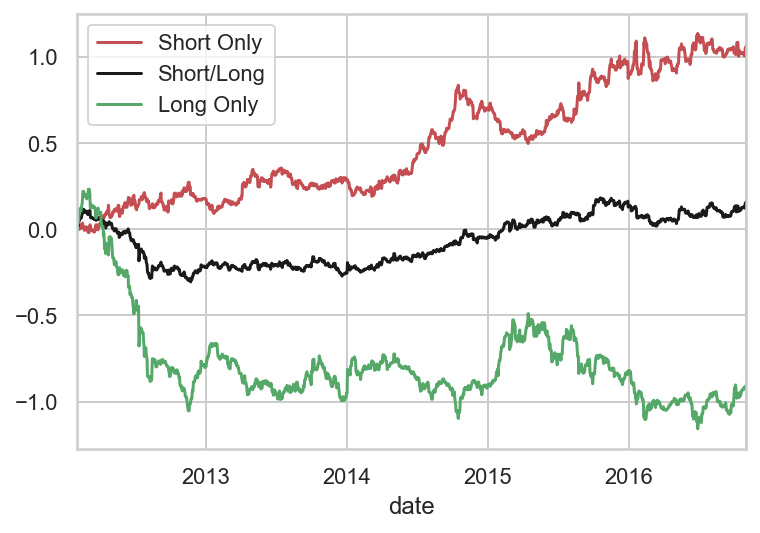

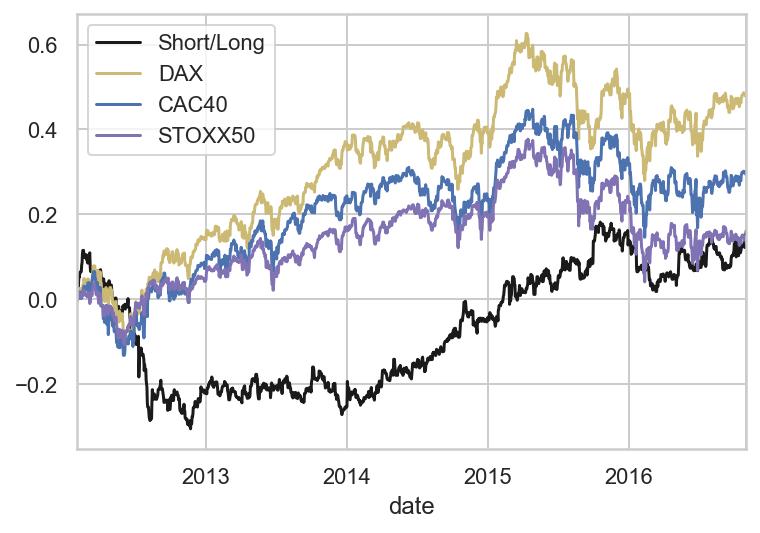

In [32]:
backtest_report(
    data,
    features,
    xgb_clf,
    test_start="2012-01-01",
    test_end="2016-01-01",
    months=3,
    n=10,
    weight="equal")